In [802]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [803]:
data = pd.read_csv("data/crime.csv")

In [804]:
comptes_categorie = data['Category'].value_counts()
comptes_categorie

Category
LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQ

In [805]:

categories_to_remove = ["NON-CRIMINAL", "WARRANTS", "OTHER OFFENSES", "RECOVERED VEHICLE", "SUSPICIOUS OCC", "TREA",
                        "PORNOGRAPHY/OBSCENE MAT", "PORNOGRAPHY/OBSCENE MAT", "GAMBLING", "LOITERING", "LIQUOR LAWS",
                        "WEAPON LAWS", "SECONDARY CODES", "MISSING PERSON", "SEX OFFENSES NON FORCIBLE"]

data = data[~data['Category'].isin(categories_to_remove)]


In [806]:
value_count = data['Category'].value_counts()
print(len(value_count))
min_cat_count = value_count.min()
min_cat_count

25


256

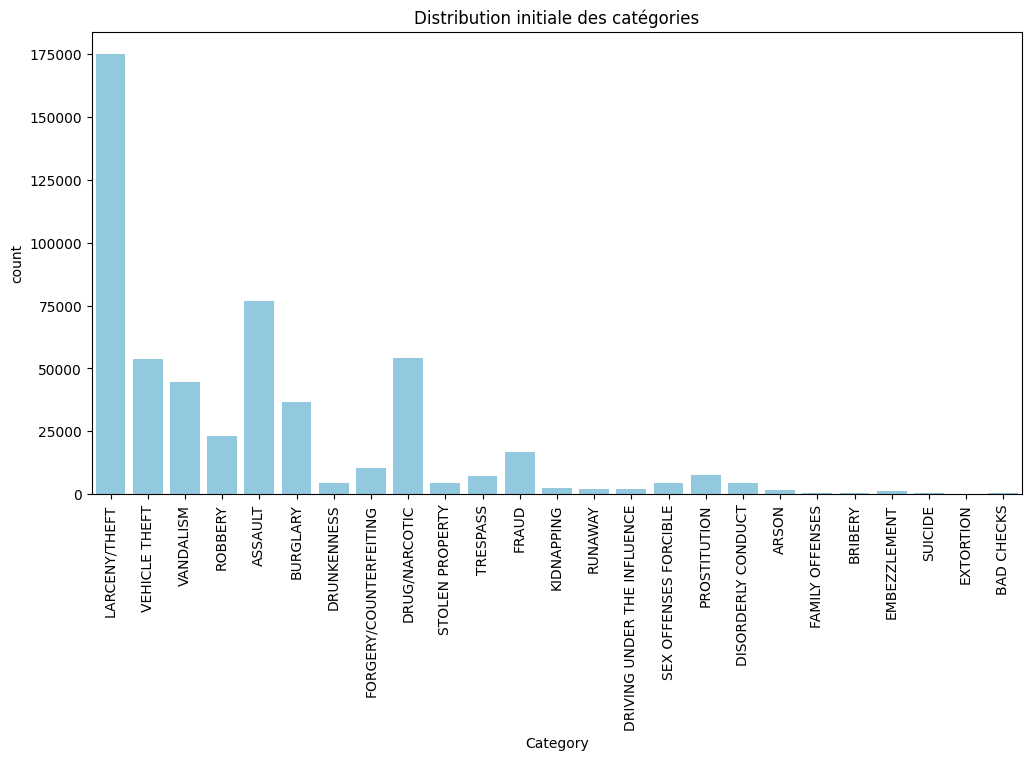

In [807]:
plt.figure(figsize=(12, 6))
sns.countplot(x=data["Category"], color='skyblue')
plt.title('Distribution initiale des catégories')
plt.xticks(rotation=90)
plt.show()

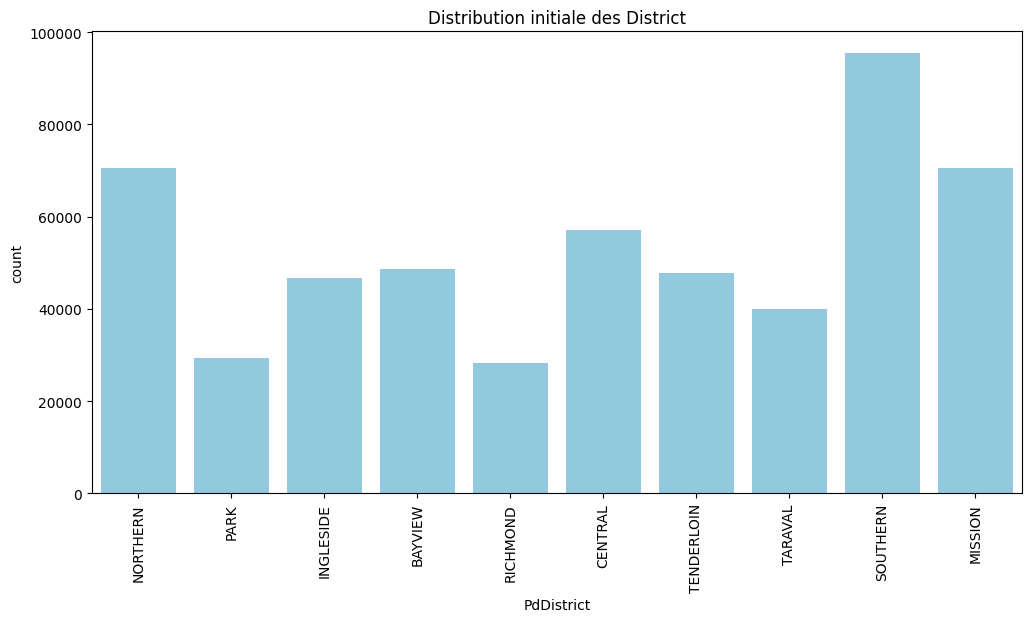

In [808]:
plt.figure(figsize=(12, 6))
sns.countplot(x=data["PdDistrict"], color='skyblue')
plt.title('Distribution initiale des District')
plt.xticks(rotation=90)
plt.show()

In [809]:
pre_balanced_data = []
min_cat_count = 10000
for category in data['Category'].unique():
    category_data = data[data['Category'] == category]

    if len(category_data) > min_cat_count:
        sampled_data = category_data.sample(min_cat_count, random_state=42)
        pre_balanced_data.append(sampled_data)
    else:
        duplicated_data = pd.concat([category_data] * (min_cat_count // len(category_data)), ignore_index=True)
        pre_balanced_data.append(duplicated_data)

In [810]:
pre_balanced_data = pd.concat(pre_balanced_data, ignore_index=True)


In [812]:
balanced_data = []
for district in pre_balanced_data['PdDistrict'].unique():
    district_data = pre_balanced_data[pre_balanced_data["PdDistrict"] == district]
    
    if len(district_data) > 10000:
        sampled_data = district_data.sample(10000, random_state=42)
        balanced_data.append(sampled_data)

    else:
        duplicated_data = pd.concat([district_data] * (10000 // len(district_data)), ignore_index=True)
        balanced_data.append(duplicated_data)


In [813]:
balanced_data = pd.concat(balanced_data, ignore_index=True)

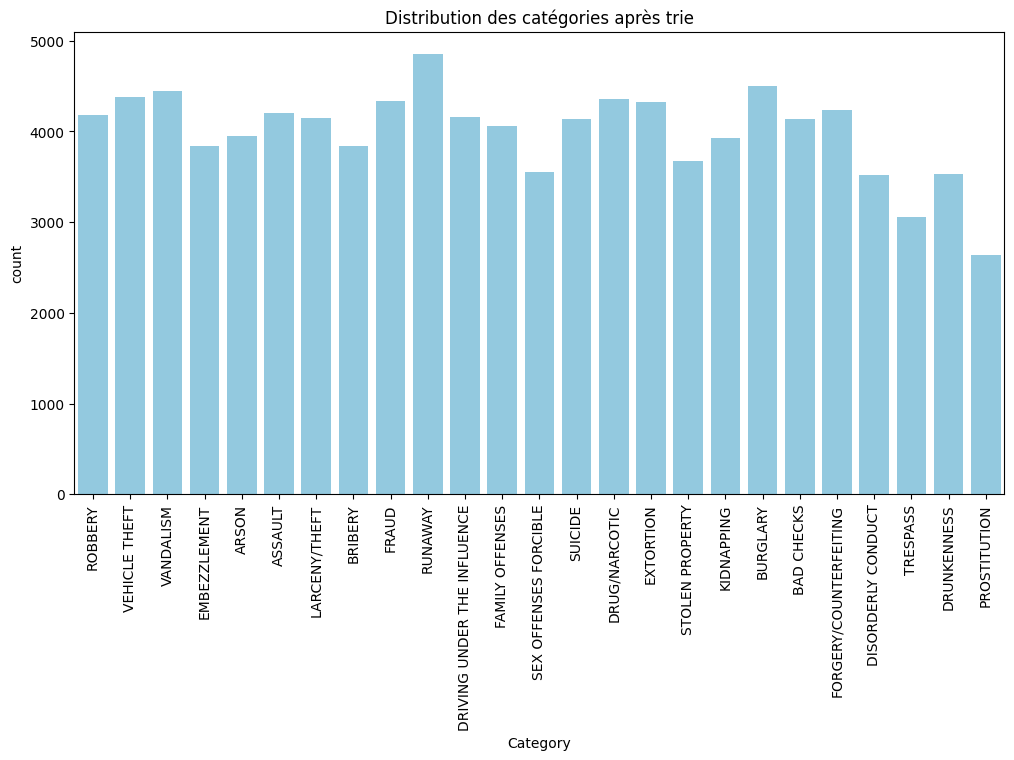

In [814]:
plt.figure(figsize=(12, 6))
sns.countplot(x=balanced_data["Category"], color='skyblue')
plt.title('Distribution des catégories après trie')
plt.xticks(rotation=90)
plt.show()

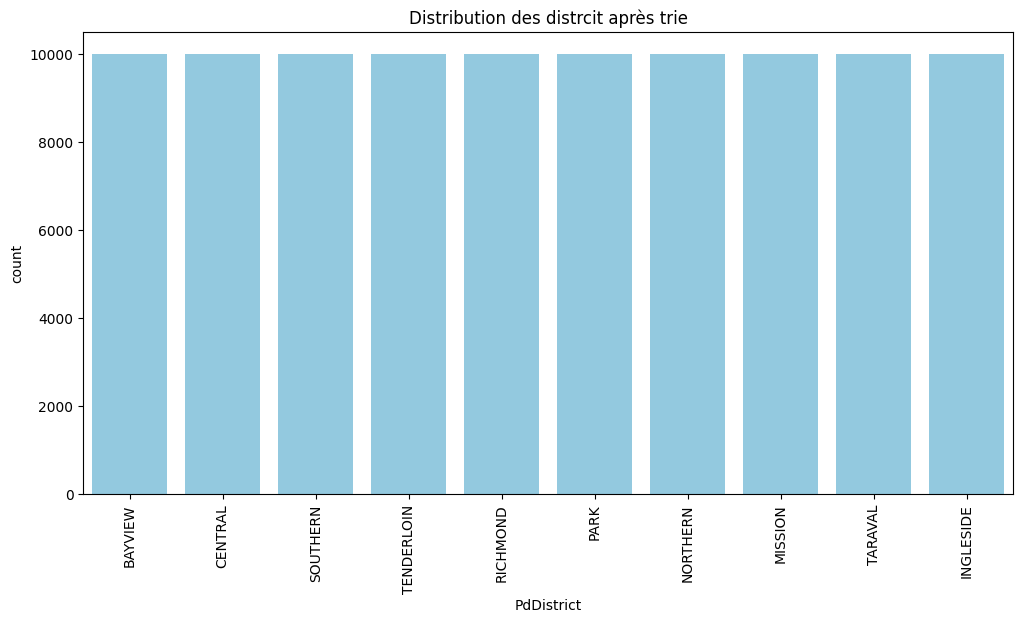

In [815]:
plt.figure(figsize=(12, 6))
sns.countplot(x=balanced_data["PdDistrict"], color='skyblue')
plt.title('Distribution des distrcit après trie')
plt.xticks(rotation=90)
plt.show()

In [816]:
balanced_data["Hour"] = pd.to_datetime(balanced_data["Dates"]).dt.hour

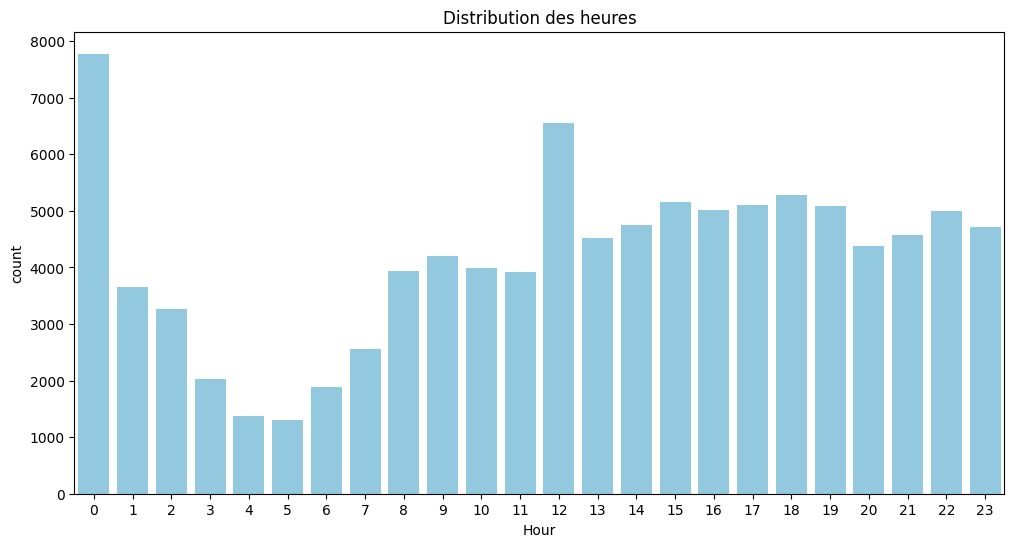

In [817]:
plt.figure(figsize=(12, 6))
sns.countplot(x=balanced_data["Hour"], color='skyblue')
plt.title('Distribution des heures')
plt.show()

In [818]:
train_data, test_data = train_test_split(balanced_data, test_size=0.2, random_state=42)

train_data

Dates                     Category  \
75220  2013-11-11 14:42:00  DRIVING UNDER THE INFLUENCE   
48955  2005-05-19 11:00:00                   BAD CHECKS   
44966  2004-09-05 17:30:00              FAMILY OFFENSES   
13568  2008-09-02 19:00:00                 EMBEZZLEMENT   
92727  2009-08-20 07:00:00                      SUICIDE   
...                    ...                          ...   
6265   2013-10-01 21:00:00                VEHICLE THEFT   
54886  2008-10-19 06:10:00                      SUICIDE   
76820  2013-06-26 08:15:00                   KIDNAPPING   
860    2011-04-19 07:35:00              FAMILY OFFENSES   
15795  2004-08-07 00:48:00       FORGERY/COUNTERFEITING   

                                           Descript  DayOfWeek PdDistrict  \
75220  DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL     Monday    MISSION   
48955    CHECKS, NON-SUFFICIENT FUNDS (MISDEMEANOR)   Thursday   RICHMOND   
44966                            DESERTION OF CHILD     Sunday   RICHMOND   
13568                     EMBEZZLEMENT, GRAND THEFT    Tuesday    CENTRAL   
92727                           SUICIDE BY FIREARMS   Thursday  INGLESIDE   
...                                             ...        ...        ...   
6265                              STOLEN AUTOMOBILE    Tuesday    BAYVIEW   
54886                             ATTEMPTED SUICIDE     Sunday       PARK   
76820                            FALSE IMPRISONMENT  Wednesday    MISSION   
860                    FAILURE TO PROVIDE FOR CHILD    Tuesday    BAYVIEW   
15795           FORGERY, DRIVERS LICENSE OR ID-CARD   Saturday    CENTRAL   

            Resolution                         Address           X          Y  \
75220   ARREST, BOOKED               21ST ST / CAPP ST -122.417813  37.757101   
48955             NONE            700 Block of 19TH AV -122.477763  37.773782   
44966   ARREST, BOOKED            500 Block of 45TH AV -122.506023  37.778135   
13568             NONE     1400 Block of CALIFORNIA ST -122.418239  37.790933   
92727             NONE            1400 Block of NOE ST -122.431437  37.746224   
...                ...                             ...         ...        ...   
6265              NONE            LANE ST / QUESADA AV -122.389603  37.732290   
54886             NONE     300 Block of LAGUNAHONDA BL -122.458680  37.748155   
76820   ARREST, BOOKED  500 Block of SOUTH VAN NESS AV -122.417477  37.764358   
860    JUVENILE BOOKED         1400 Block of REVERE AV -122.387414  37.730040   
15795             NONE        300 Block of BROADWAY ST -122.403680  37.798191   

       Hour  
75220    14  
48955    11  
44966    17  
13568    19  
92727     7  
...     ...  
6265     21  
54886     6  
76820     8  
860       7  
15795     0  

[80000 rows x 10 columns]

In [819]:
features = ["DayOfWeek", "Hour"]
targets = ["Category", "PdDistrict"]

In [820]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["Hour"]),  # Normaliser l'heure
        ('cat', OneHotEncoder(), ["DayOfWeek"])  # Encoder les variables catégorielles
    ])

In [821]:

model = MultiOutputClassifier(LogisticRegression(random_state=42), n_jobs=-1)


In [822]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

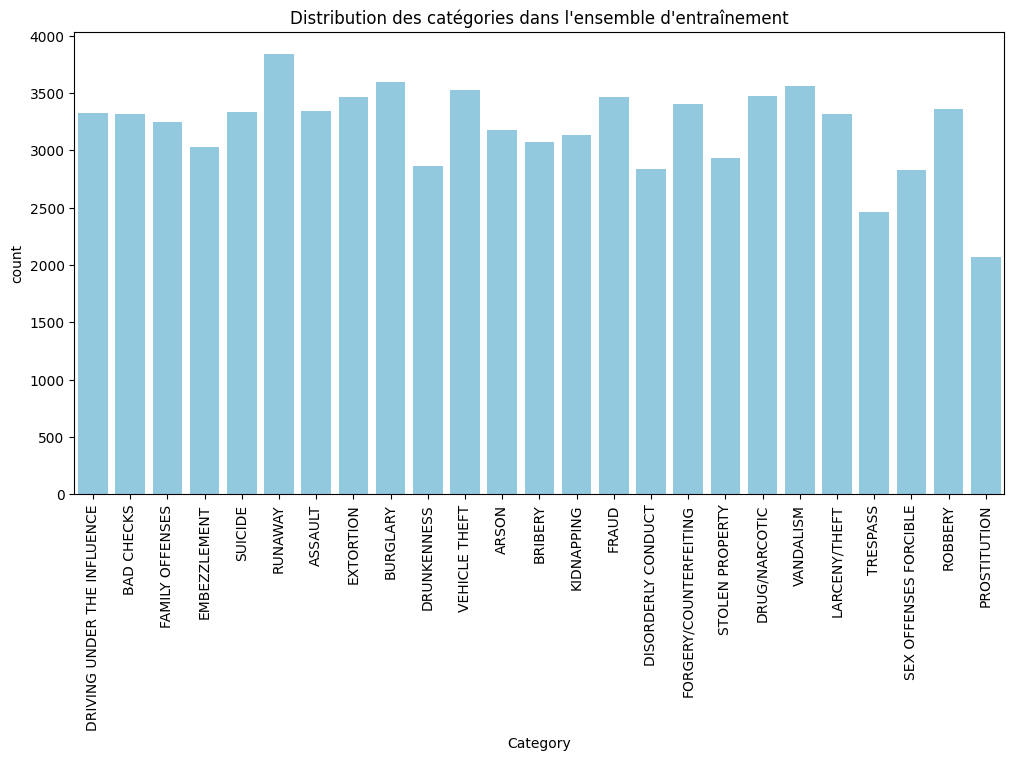

In [823]:
plt.figure(figsize=(12, 6))
sns.countplot(x=train_data["Category"], color='skyblue')
plt.title('Distribution des catégories dans l\'ensemble d\'entraînement')
plt.xticks(rotation=90)
plt.show()

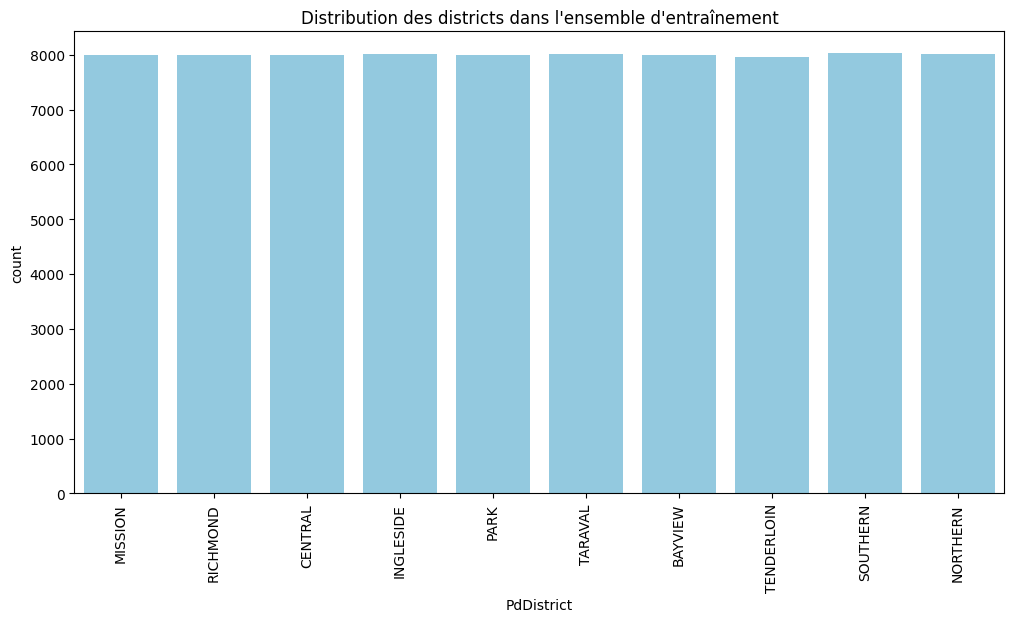

In [824]:
plt.figure(figsize=(12, 6))
sns.countplot(x=train_data["PdDistrict"], color='skyblue')
plt.title('Distribution des districts dans l\'ensemble d\'entraînement')
plt.xticks(rotation=90)
plt.show()

In [825]:
pipeline.fit(train_data[features], train_data[targets])


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Hour']),
                                                 ('cat', OneHotEncoder(),
                                                  ['DayOfWeek'])])),
                ('model',
                 MultiOutputClassifier(estimator=LogisticRegression(random_state=42),
                                       n_jobs=-1))])

In [826]:
test_predictions = pipeline.predict(test_data[features])
train_predictions = pipeline.predict(train_data[features])




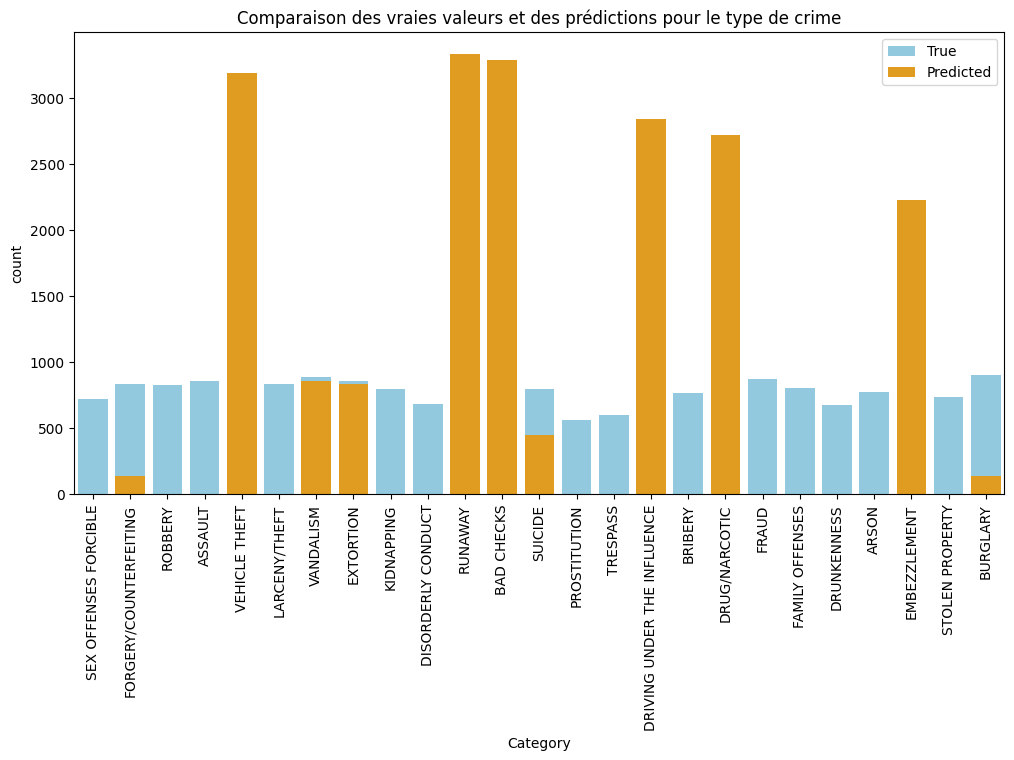

In [827]:
plt.figure(figsize=(12, 6))
sns.countplot(x=test_data["Category"], color='skyblue', label='True')
sns.countplot(x=test_predictions[:, 0], color='orange', label='Predicted')
plt.title('Comparaison des vraies valeurs et des prédictions pour le type de crime')
plt.xticks(rotation=90)
plt.legend()
plt.show()

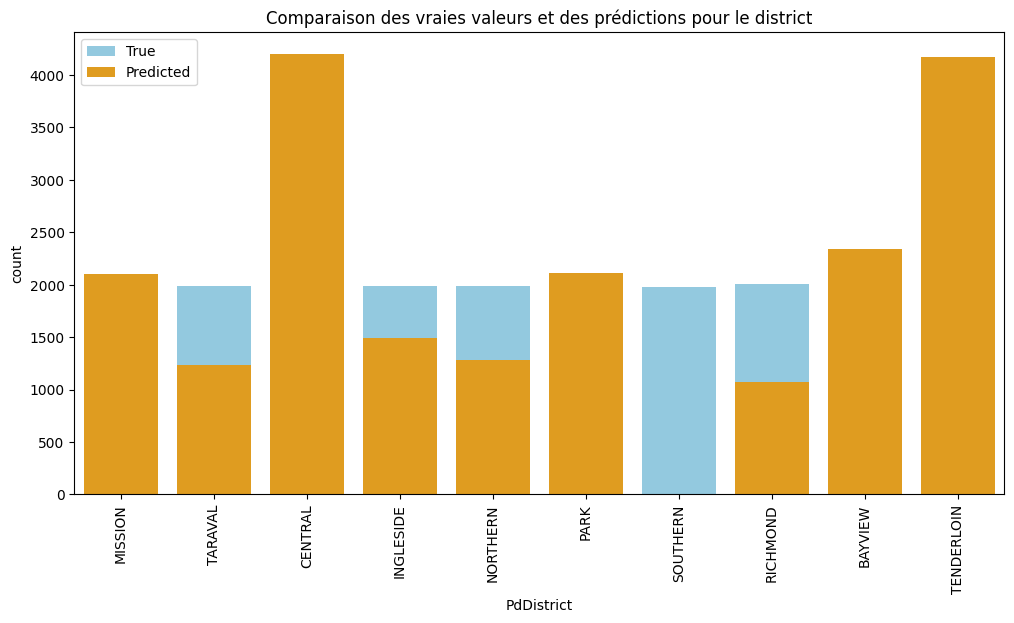

In [828]:
plt.figure(figsize=(12, 6))
sns.countplot(x=test_data["PdDistrict"], color='skyblue', label='True')
sns.countplot(x=test_predictions[:, 1], color='orange', label='Predicted')
plt.title('Comparaison des vraies valeurs et des prédictions pour le district')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [829]:
print("TRAIN METRICS")
for i, target in enumerate(targets):
    print(f"\nMetrics for {target}:")
    print("Accuracy:", accuracy_score(train_data[target], train_predictions[:, i]))
    print("Precision:", precision_score(train_data[target], train_predictions[:, i], average='weighted', zero_division=0))
    print("Recall:", recall_score(train_data[target], train_predictions[:, i], average='weighted'))
    print("F1 Score:", f1_score(train_data[target], train_predictions[:, i], average='weighted'))

TRAIN METRICS

Metrics for Category:
Accuracy: 0.0613875
Precision: 0.030215052946873266
Recall: 0.0613875
F1 Score: 0.03279428230120402

Metrics for PdDistrict:
Accuracy: 0.1094625
Precision: 0.09777322237809519
Recall: 0.1094625
F1 Score: 0.0973130335272372


In [830]:
print("TEST METRICS")
for i, target in enumerate(targets):
    print(f"\nMetrics for {target}:")
    print("Accuracy:", accuracy_score(test_data[target], test_predictions[:, i]))
    print("Precision:", precision_score(test_data[target], test_predictions[:, i], average='weighted', zero_division=0))
    print("Recall:", recall_score(test_data[target], test_predictions[:, i], average='weighted'))
    print("F1 Score:", f1_score(test_data[target], test_predictions[:, i], average='weighted'))

TEST METRICS

Metrics for Category:
Accuracy: 0.0613
Precision: 0.030772666979784095
Recall: 0.0613
F1 Score: 0.03301471853474172

Metrics for PdDistrict:
Accuracy: 0.10895
Precision: 0.09655633866035053
Recall: 0.10895
F1 Score: 0.09680423519544508


In [831]:
joblib.dump(pipeline, "data/pipeline.pkl")


['data/pipeline.pkl']